In [1]:
# Bare Minimum - One Sheet Script

In [2]:
import pandas as pd
import numpy as np
import random
from random import randrange
import time
import os
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import itertools
from itertools import permutations
from itertools import combinations
import copy

In [3]:
# Get all permutations of [1, 2, 3] 
perm = permutations([1, 2, 3]) 
 
# Print the obtained permutations 
for i in list(perm): 
    print (i) 

(1, 2, 3)
(1, 3, 2)
(2, 1, 3)
(2, 3, 1)
(3, 1, 2)
(3, 2, 1)


## Setup

In [4]:
# Environment
class world:
    def __init__(self,Size):
        self.Size = Size
        self.Fig = None
        self.Grid = None
        self.Coin_Locations = []

def Generate_Map(world):
    # generate a grid with the dimensions of world.Size
    grid = np.zeros([world.Size,world.Size])
    
    fig = plt.figure(figsize = [5,5])
    plt.xlim(0,world.Size)
    plt.ylim(0,world.Size)

    world.Grid = grid
    world.Fig = fig


def Generate_Coins(world,number_of_coins):

    for coin in range(0,number_of_coins):
        coin_location_x = randrange(0,world.Size)
        coin_location_y = randrange(0,world.Size)

        coin_location = [coin_location_x,coin_location_y]
        world.Coin_Locations.append(coin_location)

    fig = world.Fig

    for coins in range(len(world.Coin_Locations)):
        world.Grid[world.Coin_Locations[coins][0],world.Coin_Locations[coins][1]] = 1
    
    plt.imshow(world.Grid, cmap='viridis', interpolation='nearest')
    plt.show()

    


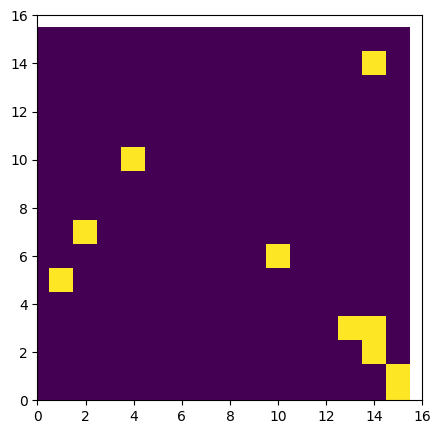

In [5]:
test_world = world(16)
Generate_Map(test_world)
Generate_Coins(test_world,10)

In [6]:
class entity:
    def __init__(self,world):
        self.world = world
        self.IsSpawned = False

        if self.IsSpawned == False:
            self.Location = [0,0]
        elif self.IsSpawned == True:
            x_loc = world.Grid[np.where(world.Grid[:,0] == max(world.Grid))]
            print('x: ',x_loc)
            y_loc = world.Grid[np.where(world.Grid[0,:] == max(world.Grid))]
            print('y: ',y_loc)
            self.Location = [x_loc,y_loc]

        self.Speed = 6
        self.Coins = 0


def Spawn(entity):
    world = entity.world
    grid = world.Grid

    grid[8,8] = 2
    
    entity.IsSpawned = True
    entity.Location = [8,8]


    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.xlim(-1,world.Size)
    plt.ylim(-1,world.Size)
    plt.grid()
    plt.show()

In [7]:
# Actions
## Search
def Search(Actor,world):
    actor_x = Actor.X
    actor_y = Actor.Y

    distances_to_coins = []
    for coin in range(len(world.Coin_Locations)):
        coin_location = world.Coin_Locations[coin]

        distance = 0
        distances_to_coins.append(distance)
    shortest_distance = distances_to_coins.sort()
    return shortest_distance[0]


## Dash
def Dash(Actor):
    env = Actor.world.Grid
    agent_pos = Actor.Location

    def create_cost_function(coins):
        def cost(position):
            # Chebyshev distance minus 1 (because agent can collect from adjacent spaces)
            distances = np.max(np.abs(coins - position), axis=1) - 1
            # Clip to ensure non-negative distances
            return np.min(np.clip(distances, 0, None))
        return cost

    def gradient(f, position, epsilon=1e-8):
        grad = np.zeros_like(position)
        for i in range(len(position)):
            h = np.zeros_like(position)
            h[i] = epsilon
            grad[i] = (f(position + h) - f(position - h)) / (2 * epsilon)
        return grad

    def gradient_descent_move(env, agent_pos, learning_rate=0.5, num_iterations=10):
        coins = np.array(np.where(env == 1)).T
        if len(coins) == 0:
            return agent_pos  # No coins left, stay in place
        
        cost_function = create_cost_function(coins)
        
        position = np.array(agent_pos, dtype=float)
        for _ in range(num_iterations):
            grad = gradient(cost_function, position)
            position -= learning_rate * grad
        
        # Ensure the position stays within the environment bounds
        position = np.clip(position, 0, np.array(env.shape) - 1)
        new_pos = np.round(position).astype(int)
        
        # Ensure the agent moves by at least one space if not already on a coin
        if np.array_equal(new_pos, agent_pos) and not np.array_equal(coins, agent_pos):
            diff = new_pos - agent_pos
            move = np.sign(diff + np.random.uniform(-0.5, 0.5, size=diff.shape)).astype(int)
            new_pos = np.clip(agent_pos + move, 0, np.array(env.shape) - 1)
        
        return new_pos
    
    next_pos = gradient_descent_move(env, agent_pos)

    if np.array_equal(next_pos, agent_pos):
        print(f"Agent stays at {agent_pos}")
    else:
        print(f"Agent moves from {agent_pos} to {next_pos}")
        
    env[tuple(agent_pos)] = 0  # Remove agent from old position
    env[tuple(next_pos)] = 2   # Place agent in new position
    Actor.Location = next_pos

    print('Dashing One Space...')
    plt.imshow(env, cmap='viridis', interpolation='nearest')
    plt.xlim(-1,Actor.world.Size)
    plt.ylim(-1,Actor.world.Size)
    plt.grid()
    plt.show()

## Object Interaction
def Object_Interaction(Actor):
    locations = Actor.world.Grid
    rows, cols = locations.shape
    
    # Find the location of the agent (value 2)
    agent_location = Actor.Location
    spaces_within_reach = []

    # Iterate over the nearby locations within ±1 distance
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            x = agent_location[0] + dx
            y = agent_location[1] + dy
            
            # Check if the location is within bounds and is not the agent's location itself
            if (0 <= x < rows) and (0 <= y < cols):
                spaces_within_reach.append([x, y])
    
    # now if only 1 of the spaces in spaces_within_reach match those from the world.Gold_Location_X or Y, then increase entity.coins by 1
    spaces_with_coins = []
    coin_locations = Actor.world.Coin_Locations
    for space in spaces_within_reach:
        for location in coin_locations:
            if space == location: 
                spaces_with_coins.append(space)
    
    if len(spaces_with_coins) == 1:
        space = spaces_with_coins[0]

        if Actor.world.Grid[space[0],space[1]] == 3:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 2
            locations[space[0],space[1]] = 2
            print('picking up coin')
        else:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 0
            locations[space[0],space[1]] = 0
            print('picking up coin')

    elif len(spaces_with_coins) > 1:
        space_choice = random.choice(spaces_with_coins)
        if Actor.world.Grid[space[0],space[1]] == 3:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 2
            locations[space[0],space[1]] = 2
            print('picking up coin')
        else:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 0
            locations[space[0],space[1]] = 0
            print('picking up coin')
    
    else: 
        print('no coins in reach')


    plt.imshow(Actor.world.Grid, cmap='viridis', interpolation='nearest')
    plt.xlim(-1,Actor.world.Size)
    plt.ylim(-1,Actor.world.Size)
    plt.grid()
    plt.show()


In [8]:
def create_cost_function(coins):
    def cost(position):
        # Chebyshev distance minus 1 (because agent can collect from adjacent spaces)
        distances = np.max(np.abs(coins - position), axis=1) - 1
        # Clip to ensure non-negative distances
        return np.min(np.clip(distances, 0, None))
    return cost

def gradient(f, position, epsilon=1e-8):
    grad = np.zeros_like(position)
    for i in range(len(position)):
        h = np.zeros_like(position)
        h[i] = epsilon
        grad[i] = (f(position + h) - f(position - h)) / (2 * epsilon)
    return grad

def gradient_descent_move(env, agent_pos, learning_rate=0.5, num_iterations=10):
    coins = np.array(np.where(env == 1)).T
    if len(coins) == 0:
        return agent_pos  # No coins left, stay in place
    
    cost_function = create_cost_function(coins)
    
    position = np.array(agent_pos, dtype=float)
    for _ in range(num_iterations):
        grad = gradient(cost_function, position)
        position -= learning_rate * grad
    
    # Ensure the position stays within the environment bounds
    position = np.clip(position, 0, np.array(env.shape) - 1)
    new_pos = np.round(position).astype(int)
    
    # Ensure the agent moves by at least one space if not already on a coin
    if np.array_equal(new_pos, agent_pos) and not np.array_equal(coins, agent_pos):
        diff = new_pos - agent_pos
        move = np.sign(diff + np.random.uniform(-0.5, 0.5, size=diff.shape)).astype(int)
        new_pos = np.clip(agent_pos + move, 0, np.array(env.shape) - 1)
    
    return new_pos

def collect_coins(env, agent_pos):
    coins_collected = 0
    # Check all adjacent spaces (including diagonals)
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            check_pos = agent_pos + np.array([dx, dy])
            if np.all(check_pos >= 0) and np.all(check_pos < env.shape):
                if env[tuple(check_pos)] == 1:
                    env[tuple(check_pos)] = 0  # Collect the coin
                    coins_collected += 1
    return env, coins_collected

# Example usage
env = np.array([
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1],
    [1, 0, 2, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0]
])

agent_pos = np.array(np.where(env == 2)).flatten()
print("Initial environment:")
print(env)

total_coins_collected = 0
for i in range(10):  # Simulate 10 moves
    next_pos = gradient_descent_move(env, agent_pos)
    if np.array_equal(next_pos, agent_pos):
        print(f"\nIteration {i+1}: Agent stays at {agent_pos}")
    else:
        print(f"\nIteration {i+1}: Agent moves from {agent_pos} to {next_pos}")
    
    env[tuple(agent_pos)] = 0  # Remove agent from old position
    env[tuple(next_pos)] = 2   # Place agent in new position
    agent_pos = next_pos
    
    env, coins_collected = collect_coins(env, agent_pos)
    total_coins_collected += coins_collected
    print(f"Coins collected this turn: {coins_collected}")
    print("Updated environment:")
    print(env)
    
    if np.sum(env == 1) == 0:
        print("All coins collected!")
        break

print(f"\nTotal coins collected: {total_coins_collected}")

Initial environment:
[[0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 2 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]]

Iteration 1: Agent moves from [2 2] to [3 3]
Coins collected this turn: 1
Updated environment:
[[0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 2 0]
 [0 1 0 0 0]]

Iteration 2: Agent moves from [3 3] to [4 4]
Coins collected this turn: 0
Updated environment:
[[0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 2]]

Iteration 3: Agent moves from [4 4] to [3 3]
Coins collected this turn: 0
Updated environment:
[[0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 2 0]
 [0 1 0 0 0]]

Iteration 4: Agent moves from [3 3] to [2 2]
Coins collected this turn: 0
Updated environment:
[[0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 2 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]

Iteration 5: Agent moves from [2 2] to [1 1]
Coins collected this turn: 2
Updated environment:
[[0 0 0 0 0]
 [0 2 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]

Iteration 6: Agent moves from [1 1] to [2 2]
Coins collected this turn: 0
Updated environment:
[[0 0 0

In [9]:
def End_Turn(Actor):
    Actor.Speed = 6

In [10]:
def New_Move_Function(Actor):
    env = Actor.world.Grid
    agent_pos = Actor.Location

    def create_cost_function(coins):
        def cost(position):
            # Chebyshev distance minus 1 (because agent can collect from adjacent spaces)
            distances = np.max(np.abs(coins - position), axis=1) - 1
            # Clip to ensure non-negative distances
            return np.min(np.clip(distances, 0, None))
        return cost

    def gradient(f, position, epsilon=1e-8):
        grad = np.zeros_like(position)
        for i in range(len(position)):
            h = np.zeros_like(position)
            h[i] = epsilon
            grad[i] = (f(position + h) - f(position - h)) / (2 * epsilon)
        return grad

    def gradient_descent_move(env, agent_pos, learning_rate=0.5, num_iterations=10):
        coins = np.array(np.where(env == 1)).T
        if len(coins) == 0:
            return agent_pos  # No coins left, stay in place
        
        cost_function = create_cost_function(coins)
        
        position = np.array(agent_pos, dtype=float)
        for _ in range(num_iterations):
            grad = gradient(cost_function, position)
            position -= learning_rate * grad
        
        # Ensure the position stays within the environment bounds
        position = np.clip(position, 0, np.array(env.shape) - 1)
        new_pos = np.round(position).astype(int)
        
        # Ensure the agent moves by at least one space if not already on a coin
        if np.array_equal(new_pos, agent_pos) and not np.array_equal(coins, agent_pos):
            diff = new_pos - agent_pos
            move = np.sign(diff + np.random.uniform(-0.5, 0.5, size=diff.shape)).astype(int)
            new_pos = np.clip(agent_pos + move, 0, np.array(env.shape) - 1)
        
        return new_pos
    
    next_pos = gradient_descent_move(env, agent_pos)

    if np.array_equal(next_pos, agent_pos):
        print(f"Agent stays at {agent_pos}")
    else:
        print(f"Agent moves from {agent_pos} to {next_pos}")
    
    if env[tuple(agent_pos)] == 2:
        env[tuple(agent_pos)] = 0  # Remove agent from old position
    elif env[tuple(agent_pos)] == 3:
        env[tuple(agent_pos)] = 1 # Remove agent from old position

    if env[tuple(next_pos)] == 1:
        env[tuple(next_pos)] = 3 # Place agent in new position
    elif env[tuple(next_pos)] == 0:
        env[tuple(next_pos)] = 2 # Placae agent in new position


    Actor.Location = next_pos

    print('Moving One Space...')
    plt.imshow(env, cmap='viridis', interpolation='nearest')
    plt.xlim(-1,Actor.world.Size)
    plt.ylim(-1,Actor.world.Size)
    plt.grid()
    plt.show()


In [11]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree

def improved_reward_function(agent_pos, env, look_ahead=3, mst_weight=0.2):
    coins = np.array(np.where(env == 1)).T
    if len(coins) == 0:
        return None, 0

    # Calculate distances to all coins
    distances = cdist([agent_pos], coins, metric='cityblock').flatten()

    # Calculate MST of coins
    coin_distances = cdist(coins, coins, metric='cityblock')
    mst = minimum_spanning_tree(coin_distances)
    mst_cost = mst.sum()

    # Calculate base rewards (inverse of distance)
    base_rewards = 1 / (distances + 1)  # +1 to avoid division by zero

    # Adjust rewards based on MST cost
    adjusted_rewards = base_rewards + mst_weight * (1 / (mst_cost + 1))

    # Look ahead simulation
    future_rewards = np.zeros_like(adjusted_rewards)
    for i, coin in enumerate(coins):
        future_env = env.copy()
        future_env[tuple(coin)] = 0  # Remove current coin
        _, future_reward = improved_reward_function(coin, future_env, look_ahead=look_ahead-1, mst_weight=mst_weight)
        future_rewards[i] = future_reward

    # Combine current and future rewards
    total_rewards = adjusted_rewards + 0.5 * future_rewards

    # Find the best coin
    best_coin_index = np.argmax(total_rewards)
    best_coin = tuple(coins[best_coin_index])
    best_reward = total_rewards[best_coin_index]

    return best_coin, best_reward

# Usage remains similar to before, but now incorporates MST heuristic
# and improved look-ahead mechanism

In [12]:
# Choose to Move
def Choose_Move(Actor):
    locations = Actor.world.Grid
    rows, cols = locations.shape
    agent_location = Actor.Location

    spaces_within_movement = []
    for dx in range(-5, 6):
        for dy in range(-5, 6):
            x = agent_location[0] + dx
            y = agent_location[1] + dy

            # Check if the location is within bounds and is not the agent's location itself
            if (0 <= x < rows) and (0 <= y < cols) and (dx != 0 or dy != 0):
                spaces_within_movement.append([x, y])

    # need to go through and rank each space on how close it is to a coin
    spaces_ranked = []
    for space in spaces_within_movement:
        # rank them on distance to coin, then sort by lowest to highest
        distances_to_coins = []
        for coin in Actor.world.Coin_Locations:
            distance_to_coin = math.dist(space,coin)
            distances_to_coins.append(distance_to_coin)
        distances_to_coins.sort(reverse=True)

        distance_to_nearest_coin = distances_to_coins[0]

        space_info = [space[0], space[1], distance_to_nearest_coin]
        spaces_ranked.append(space_info)

    # sort the spaces_ranked list by the third value in lists
    spaces_ranked.sort(key=lambda x: x[2])

    def create_heatmap(Actor, spaces_ranked):
        # Extract x, y coordinates and values
        x_coords = [space[0] for space in spaces_ranked]
        y_coords = [space[1] for space in spaces_ranked]
        values = [space[2] for space in spaces_ranked]

        # Determine the size of the grid
        x_max = max(x_coords) + 1
        y_max = max(y_coords) + 1

        # Create a 2D numpy array filled with NaN
        heatmap_data = np.full((x_max, y_max), np.nan)

        # Fill in the values
        for x, y, value in spaces_ranked:
            heatmap_data[x, y] = value

        # Create the heatmap
        plt.figure(figsize = [5,5])
        plt.imshow(heatmap_data, cmap='hot_r', interpolation='nearest')
        plt.xlim(0,Actor.world.Size)
        plt.ylim(0,Actor.world.Size)


        # Add text annotations
        #for i in range(heatmap_data.shape[0]):
        #    for j in range(heatmap_data.shape[1]):
        #        if not np.isnan(heatmap_data[i, j]):
        #            plt.text(j, i, f'{heatmap_data[i, j]:.1f}', 
        #                    ha='center', va='center', color='white')

        plt.tight_layout()
        plt.show()
    
    print('Choosing Where to Move')
    create_heatmap(Actor, spaces_ranked)
    ideal_location = spaces_ranked[0]
    if agent_location[0:1] == ideal_location[0:1]:
        return agent_location[0], agent_location[1]
    else:
        return ideal_location[0], ideal_location[1]





def Sim_Object_Interaction(Actor):
    locations = Actor.world.Grid
    rows, cols = locations.shape
        
    # Find the location of the agent (value 2)
    agent_location = Actor.Location
    
    spaces_within_reach = []

    # Iterate over the nearby locations within ±1 distance
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            x = agent_location[0] + dx
            y = agent_location[1] + dy
            
            # Check if the location is within bounds and is not the agent's location itself
            if (0 <= x < rows) and (0 <= y < cols) and (dx != 0 or dy != 0):
                spaces_within_reach.append([x, y])
    
    # now if only 1 of the spaces in spaces_within_reach match those from the world.Gold_Location_X or Y, then increase entity.coins by 1
    spaces_with_coins = []
    coin_locations = Actor.world.Coin_Locations
    for space in spaces_within_reach:
        for location in coin_locations:
            if space == location:
                spaces_with_coins.append(space)
    
    if len(spaces_with_coins) == 1:
        space = spaces_with_coins[0]

        if Actor.world.Grid[space[0],space[1]] == 3:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 2
            locations[space[0],space[1]] = 2
            print('picking up coin')
        else:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 0
            locations[space[0],space[1]] = 0
            print('picking up coin')

    elif len(spaces_with_coins) > 1:
        space_choice = random.choice(spaces_with_coins)
        if Actor.world.Grid[space[0],space[1]] == 3:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 2
            locations[space[0],space[1]] = 2
            print('picking up coin')
        else:
            Actor.Coins += 1
            Actor.world.Grid[space[0],space[1]] = 0
            locations[space[0],space[1]] = 0
            print('picking up coin')
    
    else: 
        print('no coins in reach')


def Sim_New_Move_Function(Actor):
    # create a sim version of the actor and world
    sim_Actor = copy.deepcopy(Actor)
    sim_world = copy.deepcopy(Actor.world)
    sim_Actor.world = sim_world
    
    # use gradient descent to find the best move
    env = sim_Actor.world.Grid
    agent_pos = sim_Actor.Location

    def create_cost_function(coins):
        def cost(position):
            # Chebyshev distance minus 1 (because agent can collect from adjacent spaces)
            distances = np.max(np.abs(coins - position), axis=1) - 1
            # Clip to ensure non-negative distances
            return np.min(np.clip(distances, 0, None))
        return cost
    
    def gradient(f, position, epsilon=1e-8):
        grad = np.zeros_like(position)
        for i in range(len(position)):
            h = np.zeros_like(position)
            h[i] = epsilon
            grad[i] = (f(position + h) - f(position - h)) / (2 * epsilon)
        return grad
    
    def gradient_descent_move(env, agent_pos, learning_rate=0.5, num_iterations=10):
        coins = np.array(np.where(env == 1)).T
        if len(coins) == 0:
            return agent_pos

        cost_function = create_cost_function(coins)

        position = np.array(agent_pos, dtype=float)
        for _ in range(num_iterations):
            grad = gradient(cost_function, position)
            position -= learning_rate * grad

        position = np.clip(position, 0, np.array(env.shape) - 1)
        new_pos = np.round(position).astype(int)

        if np.array_equal(new_pos, agent_pos) and not np.array_equal(coins, agent_pos):
            diff = new_pos - agent_pos
            move = np.sign(diff + np.random.uniform(-0.5, 0.5, size=diff.shape)).astype(int)
            new_pos = np.clip(agent_pos + move, 0, np.array(env.shape) - 1)

        return new_pos  
    
    next_pos = gradient_descent_move(env, agent_pos)

    #if np.array_equal(next_pos, agent_pos):
    #    print(f"Agent stays at {agent_pos}")   
    #else:
    #    print(f"Agent moves from {agent_pos} to {next_pos}")

    print(f'[simulation] agent at {agent_pos} moving to {next_pos}')

    if env[tuple(agent_pos)] == 2:
        env[tuple(agent_pos)] = 0  # Remove agent from old position
    elif env[tuple(agent_pos)] == 3:
        env[tuple(agent_pos)] = 1 # Remove agent from old position

    if env[tuple(next_pos)] == 1:
        env[tuple(next_pos)] = 3 # Place agent in new position
    elif env[tuple(next_pos)] == 0:
        env[tuple(next_pos)] = 2 # Placae agent in new position



    sim_Actor.Location = next_pos
    print(f'[simulation] moved to {next_pos}')
    

def Sim_Dash(Actor):
    sim_Actor = copy.deepcopy(Actor)
    sim_world = copy.deepcopy(Actor.world)
    sim_Actor.world = sim_world
    
    # use gradient descent to find the best move
    env = sim_Actor.world.Grid
    agent_pos = sim_Actor.Location

    def create_cost_function(coins):
        def cost(position):
            # Chebyshev distance minus 1 (because agent can collect from adjacent spaces)
            distances = np.max(np.abs(coins - position), axis=1) - 1
            # Clip to ensure non-negative distances
            return np.min(np.clip(distances, 0, None))
        return cost
    
    def gradient(f, position, epsilon=1e-8):
        grad = np.zeros_like(position)
        for i in range(len(position)):
            h = np.zeros_like(position)
            h[i] = epsilon
            grad[i] = (f(position + h) - f(position - h)) / (2 * epsilon)
        return grad
    
    def gradient_descent_move(env, agent_pos, learning_rate=0.5, num_iterations=10):
        coins = np.array(np.where(env == 1)).T
        if len(coins) == 0:
            return agent_pos

        cost_function = create_cost_function(coins)

        position = np.array(agent_pos, dtype=float)
        for _ in range(num_iterations):
            grad = gradient(cost_function, position)
            position -= learning_rate * grad

        position = np.clip(position, 0, np.array(env.shape) - 1)
        new_pos = np.round(position).astype(int)

        if np.array_equal(new_pos, agent_pos) and not np.array_equal(coins, agent_pos):
            diff = new_pos - agent_pos
            move = np.sign(diff + np.random.uniform(-0.5, 0.5, size=diff.shape)).astype(int)
            new_pos = np.clip(agent_pos + move, 0, np.array(env.shape) - 1)

        return new_pos
    
    next_pos = gradient_descent_move(env, agent_pos)

    #if np.array_equal(next_pos, agent_pos):
    #    print(f"Agent stays at {agent_pos}")
    #else:
    #    print(f"Agent moves from {agent_pos} to {next_pos}")

    print(f'[simulation] agent at {agent_pos} dashing to {next_pos}')
    env[tuple(agent_pos)] = 0  # Remove agent from old position
    # if the new position contains a coin, replace it with a 3, if the space is empty replace it with 2
    env[tuple(next_pos)] = 2

    #if env[tuple(next_pos)] == 1:
    #    env[tuple(next_pos)] = 3
    #elif env[tuple(next_pos)] == 0:
    #    env[tuple(next_pos)] = 2   # Place agent in new position
    
    sim_Actor.Location = next_pos
    print(f'[simulation] dashed to {next_pos}')
    

def evaluate_turn(turn, Actor):
    # Create deep copies of the Actor and its world to simulate the turn
        sim_Actor = copy.deepcopy(Actor)
        sim_world = copy.deepcopy(Actor.world)
        sim_Actor.world = sim_world
        locations = sim_Actor.world.Grid

        initial_coins = sim_Actor.Coins

        for action in turn:
            if action < 1:
                Sim_New_Move_Function(sim_Actor)
            elif action == 1 or action == 3:
                Sim_Object_Interaction(sim_Actor)
            elif action == 2:
                Sim_Dash(sim_Actor)

        adjacent_spaces = []
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                x = sim_Actor.Location[0] + dx
                y = sim_Actor.Location[1] + dy
                if (0 <= x < sim_world.Size) and (0 <= y < sim_world.Size) and (dx != 0 or dy != 0):
                    adjacent_spaces.append([x, y])
        
            
        turn_evaluation = 0
        # I want to prioritize coins collected, then ending the turn as close to other coins as possible, while maximizing the resources used
        #for space in adjacent_spaces:
        #    if locations[space[0], space[1]] == 1 or locations[space[0], space[1]] == 3:
        #        turn_evaluation += 1

        first_reward = turn[0]
        turn_evaluation += first_reward

        try:
            second_reward = turn[1] * 0.5 if turn[1] < 1 else 0
            turn_evaluation += second_reward
        except: 
            second_reward = 0
            turn_evaluation += second_reward

        try:
            third_reward = turn[2] * 0.25 if turn[2] < 1 else 0
            turn_evaluation += third_reward
        except:
            third_reward = 0
            turn_evaluation += third_reward

        coins_collected = sim_Actor.Coins - initial_coins
        turn_evaluation += coins_collected * 3

        length_reward = 0
        if len(turn) > 4 and len(turn) <= 6:
            length_reward = 1
        else:
            length_reward = 0

        turn_evaluation += length_reward

            #if sim_world.Grid[sim_Actor.Location[0], sim_Actor.Location[1]] == 1:  # Assuming 1 represents a coin
            #    sim_Actor.Coins += 1
            #    sim_world.Grid[sim_Actor.Location[0], sim_Actor.Location[1]] = 0  # Remove the collected coin

        return turn_evaluation

def Choose_Turn(Actor):
    # what does this function need to return?
    # it needs to return the order in which the sub-actions are taken (subactions being action, object interact, and each move step)
    
    # how should it return that in a way that is iterable/runnable?
    # the outcome will probably be returned as a list
    # that list will be a list of numbers, and the numbers will be an index for a second list that contains functions which will get called like piano keys
    # then the take_turn function will simply iterate through the list calling those functions in order
    
    # how to determine the order in which subactions should be taken?
    # the ideal subaction order will maximize the number of coins picked up
    # so I'll need to calculate a theoretical number of how many coins can be picked up per subaction permutation, sort, and choose the best

    # what type of rules are needed to determine the generation of the options?
    # 1. Moving can happen at any time but no more than 6 times total
    # 2. Object interaction can happen at any time but only once except if used as an action
    # 3. Action can only happen once and can be the Dash action or the Object Interaction action


    subaction_dict = {
        '0': 'New_Move_Function(Actor)',
        '1': 'Object_Interaction(Actor)',
        '2': 'Dash(Actor)',
        '3': 'Object_Interaction(Actor)',
    }

    def is_valid_turn(turn):
        move_count = sum(1 for action in turn if action < 1)
        object_interact_count = sum(1 for action in turn if action in [1, 3])
        action_count = sum(1 for action in turn if action in [2, 3])
        
        return (move_count <= 6 and 
                object_interact_count <= (2 if 3 in turn else 1) and 
                action_count <= 1)

    print("Generating valid turns...")
    def generate_valid_turns():
        for length in range(1, 9):  # Turns can be 1 to 8 actions long
            for turn in itertools.product(range(4), repeat=length):
                if is_valid_turn(turn):
                    yield turn

    
    print('Evaluating turns...')
    best_turn = None
    best_score = float('-inf')

    for turn in generate_valid_turns():
        score = evaluate_turn(turn, Actor)
        if score > best_score:
            best_turn = turn
            best_score = score
            print(best_score)

    #print([subaction_dict[action] for action in best_turn] if best_turn else [])
    #[subaction_dict[action] for action in best_turn] if best_turn else []
    print(best_turn)
    print(best_score)
    best_turn = list(best_turn)
    return best_turn

# Take_Turn
def Take_Turn(Actor):
    subaction_dict = {
        '0': 'New_Move_Function(Actor)',
        '1': 'Object_Interaction(Actor)',
        '2': 'Dash(Actor)',
        '3': 'Object_Interaction(Actor)',
    }

    best_turn_actions = Choose_Turn(Actor)
    
    for action in best_turn_actions:
        print('taking action: ',subaction_dict[str(action)])
        exec(subaction_dict[str(action)])
        

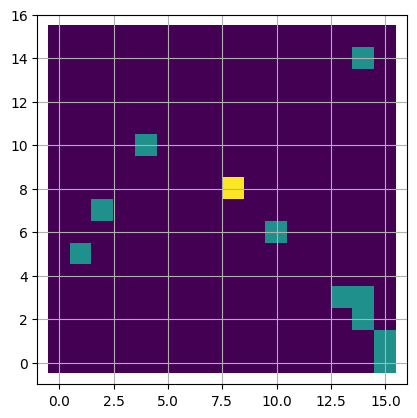

Generating valid turns...
Evaluating turns...
[simulation] agent at [8, 8] moving to [7 9]
[simulation] moved to [7 9]
0
no coins in reach
1
[simulation] agent at [8, 8] dashing to [7 9]
[simulation] dashed to [7 9]
2
no coins in reach
3
[simulation] agent at [8, 8] moving to [7 9]
[simulation] moved to [7 9]
[simulation] agent at [8, 8] moving to [7 9]
[simulation] moved to [7 9]
[simulation] agent at [8, 8] moving to [7 9]
[simulation] moved to [7 9]
no coins in reach
[simulation] agent at [8, 8] moving to [7 9]
[simulation] moved to [7 9]
[simulation] agent at [8, 8] dashing to [7 9]
[simulation] dashed to [7 9]
[simulation] agent at [8, 8] moving to [7 9]
[simulation] moved to [7 9]
no coins in reach
no coins in reach
[simulation] agent at [8, 8] moving to [7 9]
[simulation] moved to [7 9]
no coins in reach
[simulation] agent at [8, 8] dashing to [7 9]
[simulation] dashed to [7 9]
no coins in reach
no coins in reach
[simulation] agent at [8, 8] dashing to [7 9]
[simulation] dashed 

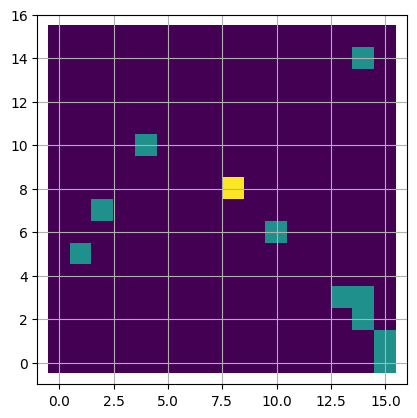

taking action:  New_Move_Function(Actor)
Agent moves from [8, 8] to [7 9]
Moving One Space...


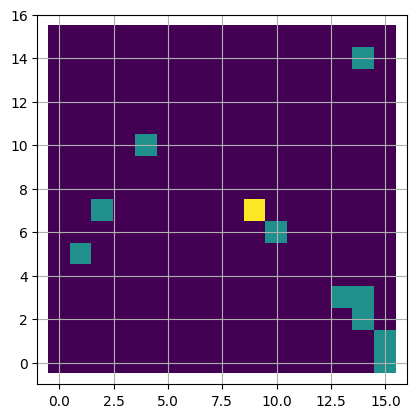

taking action:  New_Move_Function(Actor)
Agent moves from [7 9] to [ 6 10]
Moving One Space...


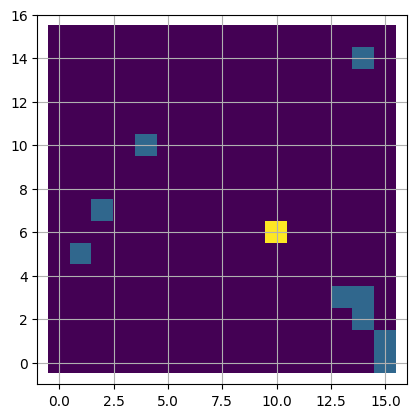

taking action:  New_Move_Function(Actor)
Agent moves from [ 6 10] to [ 4 12]
Moving One Space...


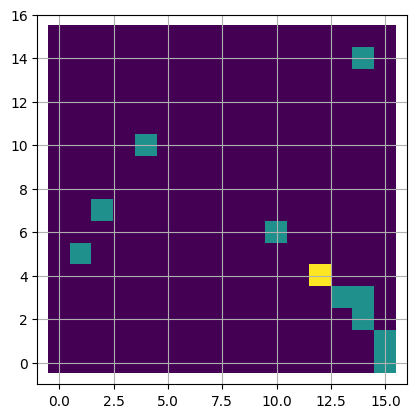

taking action:  New_Move_Function(Actor)
Agent moves from [ 4 12] to [ 5 11]
Moving One Space...


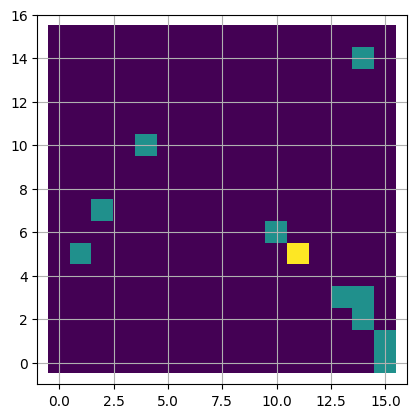

In [13]:
commoner = entity(test_world)
test_world.Grid
Spawn(commoner)
#New_Move_Function(commoner)
#Move_One(commoner)
#Object_Interaction(commoner)
Take_Turn(commoner)
#Take_Turn(commoner)
#Take_Turn(commoner)


In [14]:
commoner.Coins

0